# Plot Mean Sea Level Pressure (PSL) contours and geostrophic wind

* **Description**: Reads in and creates monthly average
* **Input data**: Rufmod output in timeseries format
* **Output data**: png with drag figure
* **Creator**: Alice DuVivier
* **Date**: August 2022

The rufmod experiments were performed where the sea ice roughness over Arctic sea ice regions was set to be equal to what it would be over open ocean. This is to better understand ice-atmosphere coupling, processes, and feedbacks. The name of the experiments is "rufmod" but they include smoother ice and will be called "smooth" below.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import pop_tools
from datetime import timedelta
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe
import metpy.calc as mpcalc
import geocat.viz.util as gvutil
from scipy.stats import linregress,pearsonr, t, ttest_ind


## Read in the processed data

This reads in pre-processed regional average atmospheric circulation for the Arctic Ocean

In [2]:
# list the variables to load
var_in_1 = 'PSL'
var_in_2 = 'UGEO'

In [3]:
# set base directory where all data live
data_dir = '/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_6/fig_4_psl_annual/'

# set file names
fin_le_1 = 'CESM2-LE_seas_'+var_in_1
fin_smooth_1 = 'rufmod_seas_'+var_in_1

fin_le_2 = 'CESM2-LE_seas_'+var_in_2
fin_smooth_2 = 'rufmod_seas_'+var_in_2

In [4]:
ds_le_1 = xr.open_dataset(data_dir+fin_le_1+'.nc',decode_times=True)
ds_smooth_1 = xr.open_dataset(data_dir+fin_smooth_1+'.nc',decode_times=True)

ds_le_2 = xr.open_dataset(data_dir+fin_le_2+'.nc',decode_times=True)
ds_smooth_2 = xr.open_dataset(data_dir+fin_smooth_2+'.nc',decode_times=True)

In [5]:
data_le_1 = ds_le_1['__xarray_dataarray_variable__']
data_smooth_1 = ds_smooth_1['__xarray_dataarray_variable__']

data_le_2 = ds_le_2['__xarray_dataarray_variable__']
data_smooth_2 = ds_smooth_2['__xarray_dataarray_variable__']

print(data_le_1.units)
print(data_le_1.longname)
print(data_le_2.units)
print(data_le_2.longname)

Pa
sea level pressure
m/s
geostrophic wind speed at given plevels


## Mask Arctic Ocean only

In [6]:
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_5/mask_plots/ATM_MASK_ArcOc.nc')


In [7]:
my_mask = ds_masks['atm_ArcOc_mask']

In [8]:
my_mask

<xarray.DataArray 'atm_ArcOc_mask' (lat: 192, lon: 288)>
dask.array<open_dataset-da90c46d10fd21b010e08c82e53c0a7aatm_ArcOc_mask, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

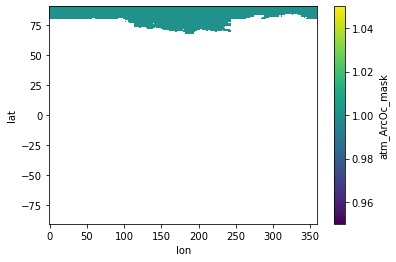

In [9]:
my_mask.plot()

In [10]:
# get just NH slice
my_mask = my_mask.isel(lat=slice(164,192))

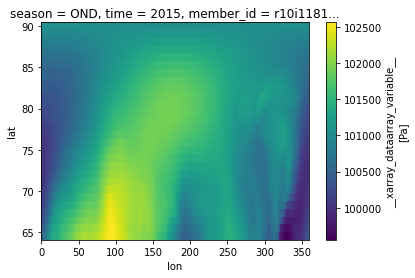

In [11]:
# check data
data_le_1.isel(season=0,member_id=0,time=0).plot()

In [12]:
# set lat/lon the same as mask so it doesn't get messed up
data_le_1['lat'] = my_mask.lat
data_le_1['lon'] = my_mask.lon

data_smooth_1['lat'] = my_mask.lat
data_smooth_1['lon'] = my_mask.lon

data_le_2['lat'] = my_mask.lat
data_le_2['lon'] = my_mask.lon

data_smooth_2['lat'] = my_mask.lat
data_smooth_2['lon'] = my_mask.lon

In [13]:
# mask just Arctic Ocean
data_le_1_masked = data_le_1.where(my_mask==1)
data_smooth_1_masked = data_smooth_1.where(my_mask==1)

data_le_2_masked = data_le_2.where(my_mask==1)
data_smooth_2_masked = data_smooth_2.where(my_mask==1)

In [14]:
print(data_le_1_masked.shape)
print(data_smooth_1_masked.shape)

(4, 86, 50, 28, 288)
(4, 86, 5, 28, 288)


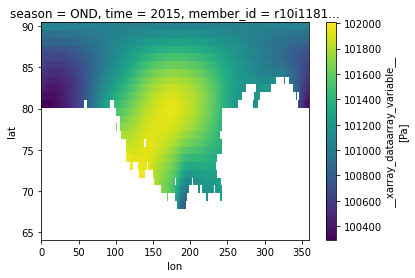

In [15]:
#just test that it worked properly
data_le_1_masked.isel(season=0,member_id=0,time=0).plot()

In [16]:
data_le_1_masked

<xarray.DataArray '__xarray_dataarray_variable__' (season: 4, time: 86, member_id: 50, lat: 28, lon: 288)>
dask.array<where, shape=(4, 86, 50, 28, 288), dtype=float64, chunksize=(4, 86, 50, 28, 288), chunktype=numpy.ndarray>
Coordinates:
  * season     (season) object 'OND' 'JFM' 'AMJ' 'JAS'
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * member_id  (member_id) object 'r10i1181p1f1' ... 'r9i1301p1f1'
  * lat        (lat) float64 64.55 65.5 66.44 67.38 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    Author:    Alice DuVivier
    units:     Pa
    longname:  sea level pressure

## Convert units and grab just 925hPa

In [17]:
# convert PSL to hPa
data_le_psl = data_le_1/100.
data_smooth_psl = data_smooth_1/100.

In [18]:
plev_all = data_le_2_masked.plev
plev_full = ['925', '850', '700', '500']

In [19]:
plev_all

<xarray.DataArray 'plev' (plev: 4)>
array([92500, 85000, 70000, 50000])
Coordinates:
  * plev     (plev) int64 92500 85000 70000 50000

In [20]:
plev = 92500

In [21]:
data_le_925 = data_le_2_masked.sel(plev = plev)
data_smooth_925 = data_smooth_2_masked.sel(plev = plev)

## Calculate decadal and ensemble means

In [22]:
# find total years
xarr_le = data_le_925.coords['time']
xarr_smooth = data_smooth_925.coords['time']

In [23]:
season_names = data_le_925.season

In [24]:
#specify some arrays that will become coordinate arrays
decades = list(range(2020,2100,10))
decade_names = ['2020','2030','2040','2050','2060','2070','2080','2090']

In [25]:
decades

[2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]

In [26]:
# Loop through decades - rufmod
print('Calculating Decadal and Ensemble Means - SMOOTH and CESM2-LE')

# make numpy array to fill and specify dimensions we want
array_smooth_1 = np.zeros([len(decades),len(season_names),len(data_le_925.lat),len(data_le_925.lon)])
array_smooth_2 = np.zeros([len(decades),len(season_names),len(data_le_925.lat),len(data_le_925.lon)])
# make numpy array to fill and specify dimensions we want
array_le_1 = np.zeros([len(decades),len(season_names),len(data_le_925.lat),len(data_le_925.lon)])
array_le_2 = np.zeros([len(decades),len(season_names),len(data_le_925.lat),len(data_le_925.lon)])
# make numpy array to fill and specify dimensions we want
array_sig = np.zeros([len(decades),len(season_names),len(data_le_925.lat),len(data_le_925.lon)])

# decade loop
for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 2020:
        count = 0
    else: 
        count = count+1
    # set the start and end years for this decade
    yy_st = dec
    yy_ed = yy_st + 10
    yy = list(range(yy_st,yy_ed,1))
    
    # PSL - SMOOTH
    # subset the data for these years only but keep all months
    temp1 = data_smooth_psl.isel(time=data_smooth_psl.time.isin([yy]))
    # stack so we can average over years and ensembles at once
    temp2 = temp1.stack(all_times=("time","member_id"))
    # average over everything
    array_smooth_1[count,:,:,:] = temp2.mean(dim='all_times')
    
    # PSL - CESM2-LE
    # subset the data for these years only but keep all months
    temp1 = data_le_psl.isel(time=data_le_psl.time.isin([yy]))
    # stack so we can average over years and ensembles at once
    temp2 = temp1.stack(all_times=("time","member_id"))
    # average over everything
    array_le_1[count,:,:,:] = temp2.mean(dim='all_times')    
    
    
    # 925hPa GPZ - SMOOTH
    # subset the data for these years only but keep all months
    temp1 = data_smooth_925.isel(time=data_smooth_925.time.isin([yy]))
    # stack so we can average over years and ensembles at once
    temp2 = temp1.stack(all_times=("time","member_id"))
    # average over everything
    array_smooth_2[count,:,:,:] = temp2.mean(dim='all_times')
    # keep the array for significance calc
    temp_sig1 = temp2
    
    # 925hPa GPZ - CESM2-LE
    # subset the data for these years only but keep all months
    temp1 = data_le_925.isel(time=data_le_925.time.isin([yy]))
    # stack so we can average over years and ensembles at once
    temp2 = temp1.stack(all_times=("time","member_id"))
    # average over everything
    array_le_2[count,:,:,:] = temp2.mean(dim='all_times')   
    # keep the array for significance calc
    temp_sig2 = temp2
    
    # calculate statistical significance of the differences
    sigval = 0.05
    tval,pval = ttest_ind(temp_sig1,temp_sig2,axis=3,equal_var=False)    
    array_sig[count,:,:,:] = pval        

Calculating Decadal and Ensemble Means - SMOOTH and CESM2-LE
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [27]:
print(array_smooth_1.shape)
print(array_le_1.shape)

(8, 4, 28, 288)
(8, 4, 28, 288)


In [29]:
# convert the numpy array to a xarray for easier plotting
seas_dec_le_psl = xr.DataArray(array_le_1,dims=('decades','season','lat','lon'))
seas_dec_smooth_psl = xr.DataArray(array_smooth_1,dims=('decades','season','lat','lon'))
seas_dec_le_925 = xr.DataArray(array_le_2,dims=('decades','season','lat','lon'))
seas_dec_smooth_925 = xr.DataArray(array_smooth_2,dims=('decades','season','lat','lon'))
seas_dec_sig = xr.DataArray(array_sig,dims=('decades','season','lat','lon'))

In [30]:
# set coordinate arrays
seas_dec_le_psl['decades'] = decade_names
seas_dec_le_psl['season'] = season_names
seas_dec_le_psl['lat'] = data_le_psl['lat'].values
seas_dec_le_psl['lon'] = data_le_psl['lon'].values

seas_dec_le_925['decades'] = decade_names
seas_dec_le_925['season'] = season_names
seas_dec_le_925['lat'] = data_le_psl['lat'].values
seas_dec_le_925['lon'] = data_le_psl['lon'].values

seas_dec_smooth_psl['decades'] = decade_names
seas_dec_smooth_psl['season'] = season_names
seas_dec_smooth_psl['lat'] = data_smooth_psl['lat'].values
seas_dec_smooth_psl['lon'] = data_smooth_psl['lon'].values

seas_dec_smooth_925['decades'] = decade_names
seas_dec_smooth_925['season'] = season_names
seas_dec_smooth_925['lat'] = data_smooth_psl['lat'].values
seas_dec_smooth_925['lon'] = data_smooth_psl['lon'].values

seas_dec_sig['decades'] = decade_names
seas_dec_sig['season'] = season_names
seas_dec_sig['lat'] = data_smooth_psl['lat'].values
seas_dec_sig['lon'] = data_smooth_psl['lon'].values

## Mask everything below 70N

In [31]:
seas_dec_le_psl = seas_dec_le_psl.where(seas_dec_le_psl.lat >70)
seas_dec_le_925 = seas_dec_le_925.where(seas_dec_le_925.lat >70)
seas_dec_smooth_psl = seas_dec_smooth_psl.where(seas_dec_smooth_psl.lat >70)
seas_dec_smooth_925 = seas_dec_smooth_925.where(seas_dec_smooth_925.lat >70)
seas_dec_sig = seas_dec_sig.where(seas_dec_sig.lat >70)

## Plotting

### General plotting data

In [32]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

### Now Plot - spatial plots by decade

In [33]:
season_names = ['OND','JFM', 'AMJ', 'JAS']
season_list = ['Autumn', 'Winter', 'Spring', 'Summer']

Plotting season OND


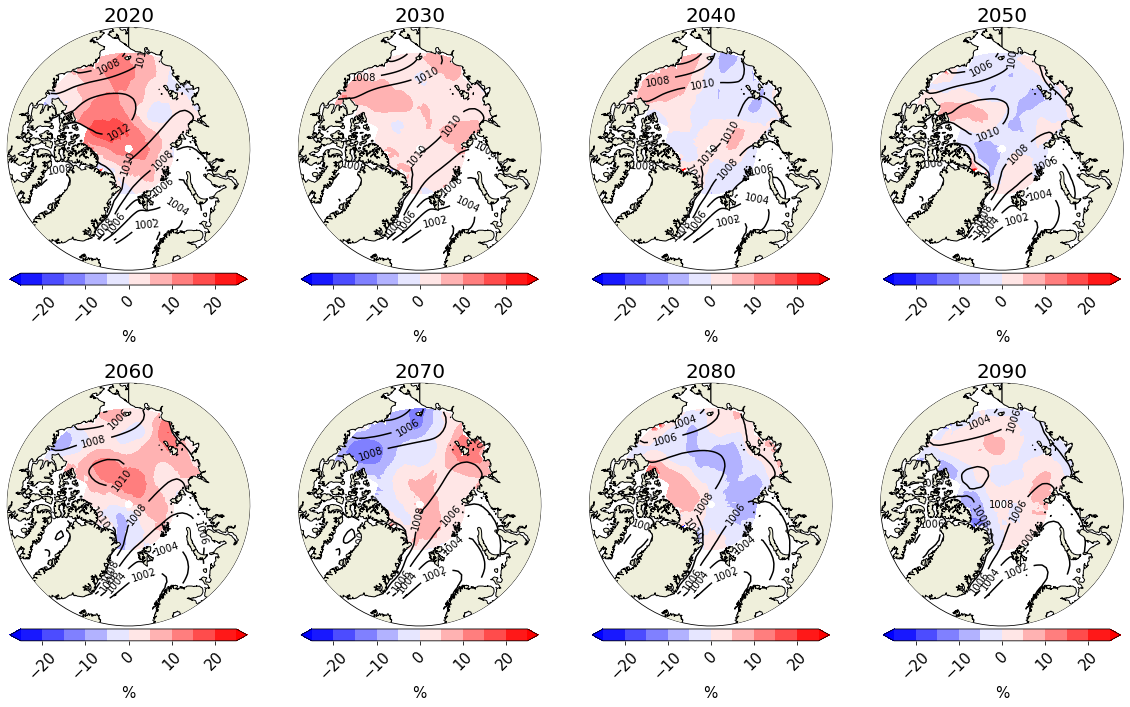

In [38]:
# set units
units = '%'

#PSL levels
levels_in = np.arange(950,1050,2) 
#UGEO levels
levels_diff = np.arange(-25,30,5)
cmap_diff = plt.cm.get_cmap('bwr') 

for ss in season_names[0:1]:
    print('Plotting season '+ss)
    if ss == 'OND':
        s_count = 0
    else:
        s_count = s_count+1
    
    # create figure
    fig = plt.figure(figsize=(20,12))
    fout = 'decadal_'+var_in_1+'_'+var_in_2+'_'+ss+'_925'
    title = season_list[s_count]+' Mean Sea Level Pressure'
    
    for dd in decade_names:
        if dd == '2020':
            count = 1
        else: 
            count = count+1
        # grab PSL data to plot
        temp_le_psl = seas_dec_le_psl.sel(season=ss,decades=dd)
        temp_smooth_psl = seas_dec_smooth_psl.sel(season=ss,decades=dd)
        # grab 925hPA data to plot
        temp_le_925 = seas_dec_le_925.sel(season=ss,decades=dd)
        temp_smooth_925 = seas_dec_smooth_925.sel(season=ss,decades=dd)
        diff = 100*((temp_smooth_925 - temp_le_925)/temp_le_925)
        # add cyclic point
        temp_le_psl = gvutil.xr_add_cyclic_longitudes(temp_le_psl,"lon")
        temp_smooth_psl = gvutil.xr_add_cyclic_longitudes(temp_smooth_psl,"lon")
        diff = gvutil.xr_add_cyclic_longitudes(diff,"lon")            
            
        # Make subplots - note it's nrow x ncol x index (starting upper left)
        ax = fig.add_subplot(2,4,count, projection=ccrs.NorthPolarStereo())
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
        # Plot the 925hPa geostrophic wind speed difference
        this = ax.contourf(diff.lon,diff.lat,
                           diff,
                           cmap=cmap_diff,levels=levels_diff,extend='both',
                           transform=ccrs.PlateCarree())
        # add colorbar
        cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
        cbar.ax.tick_params(labelsize=15, labelrotation=45)
        cbar.ax.set_xlabel(units, fontsize=15)
        #CESM2-LE PSL overlay
        color = 'black'
        linestyle = 'solid'
        this = ax.contour(temp_le_psl.lon,temp_le_psl.lat,
                          temp_le_psl,
                          transform=ccrs.PlateCarree(),
                          colors = color, linestyles = linestyle, levels = levels_in)
        plt.clabel(this,colors=color,inline=1,fontsize=10,levels=levels_in)
        #SMOOTH
        linestyle = 'dotted'
        this = ax.contour(temp_smooth_psl.lon,temp_smooth_psl.lat,
                          temp_smooth_psl,
                          colors = color, linestyles = linestyle, levels = levels_in)
        plt.clabel(this,colors=color,inline=1,fontsize=10,levels=levels_in)
        # add title
        plt.title(dd,fontsize=20)

    # Finalize figure and save
    #fig.suptitle(title,fontsize=15, y=0.75)  
    #fig.subplots_adjust(bottom=0.45,wspace=0.1)
    #fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200

Plotting season OND
Plotting season JFM
Plotting season AMJ
Plotting season JAS


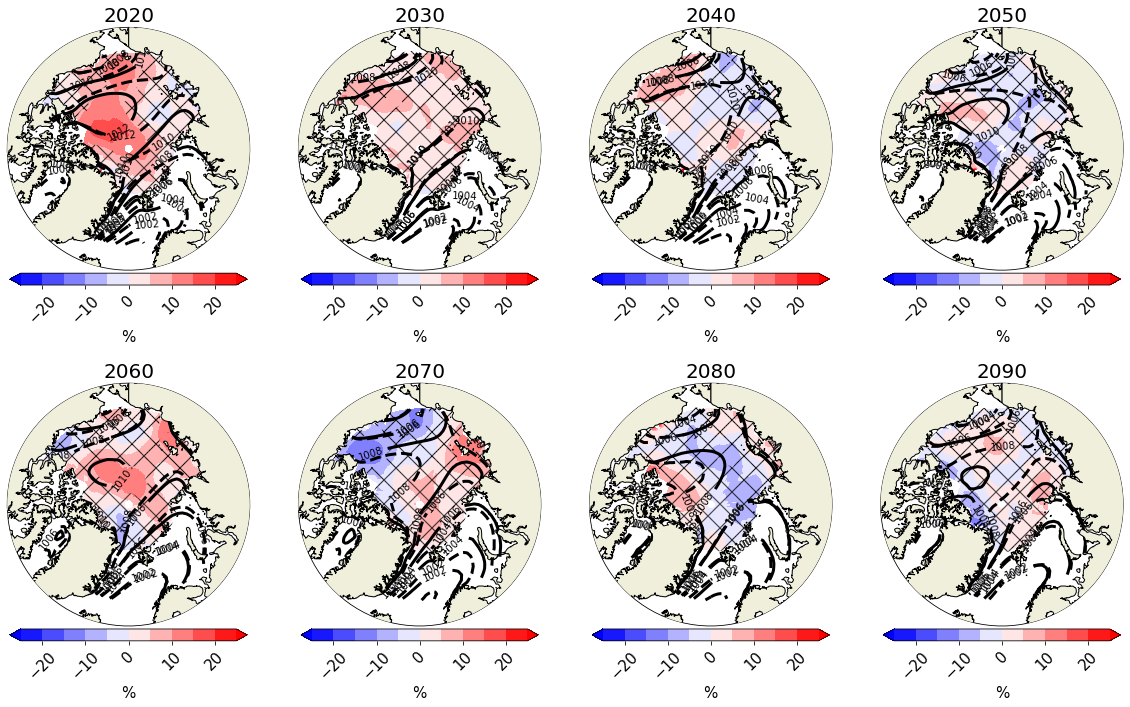

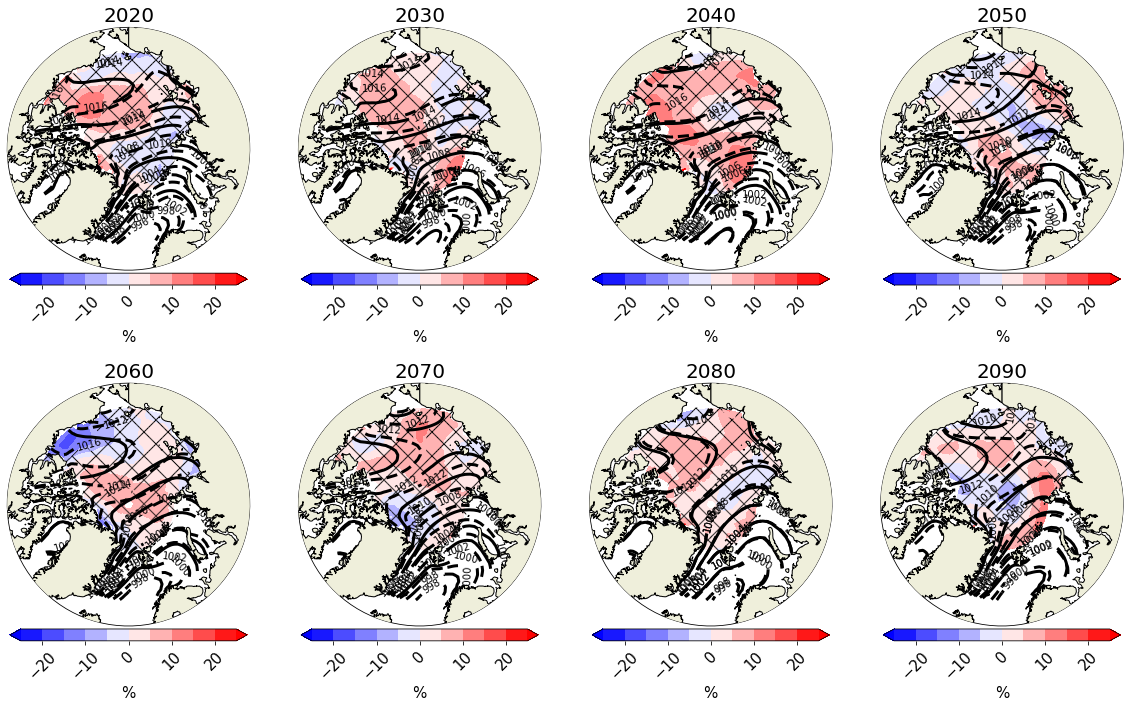

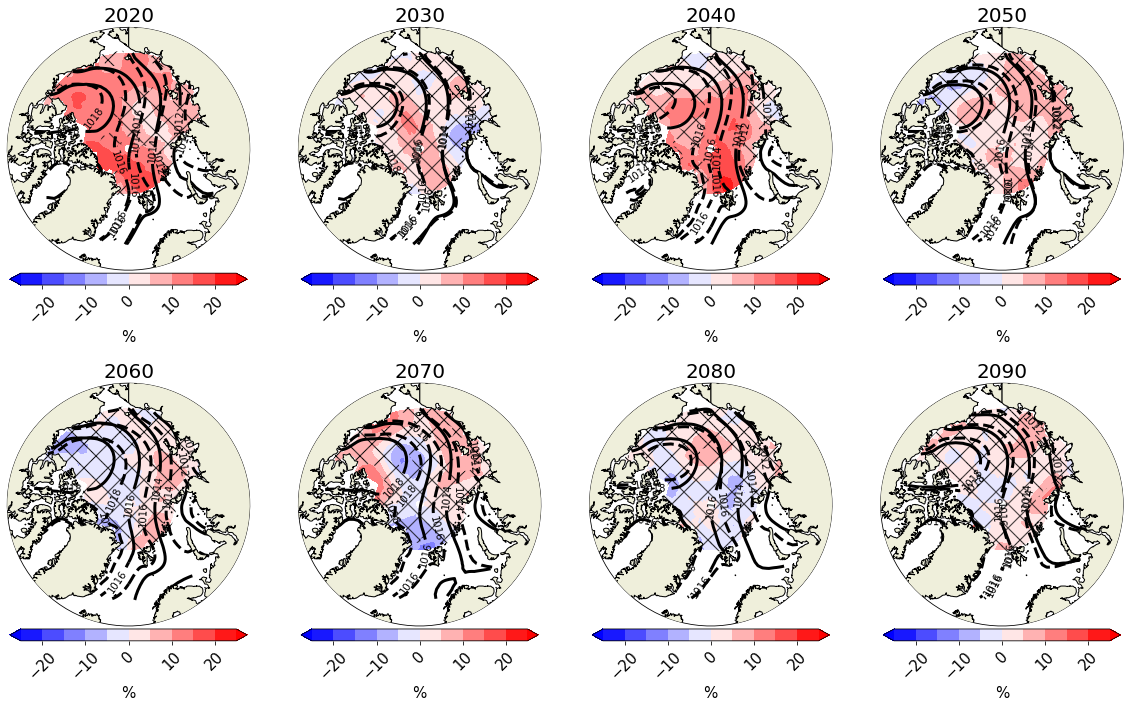

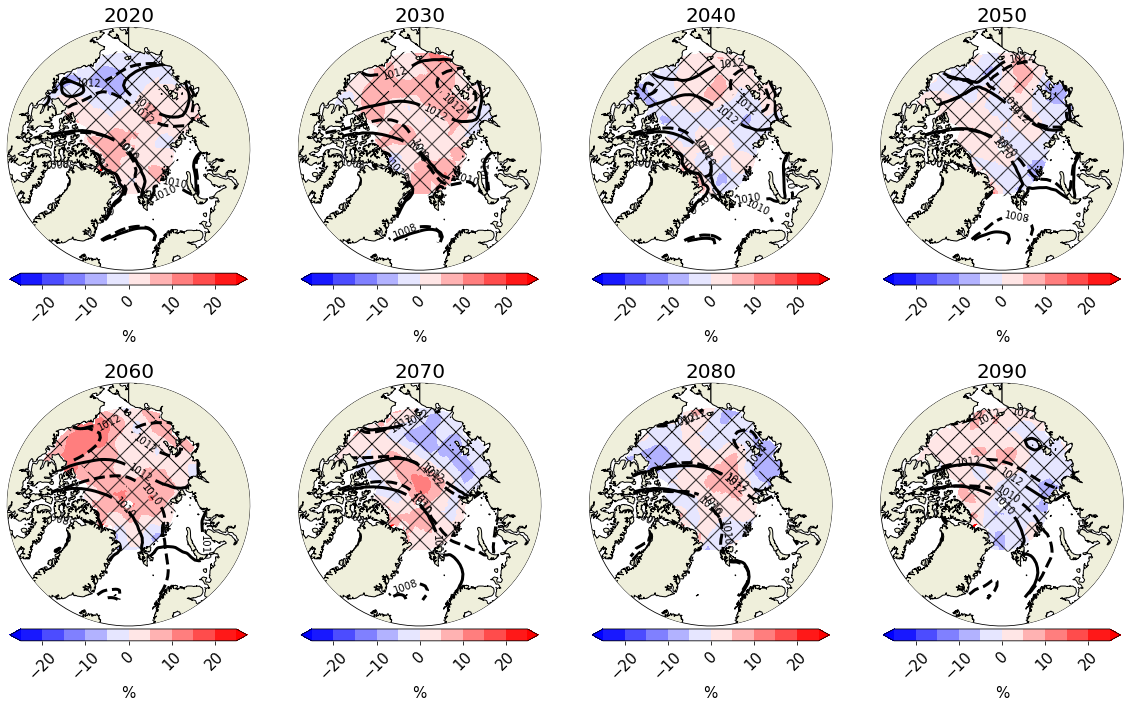

In [61]:
# set units
units = '%'

#PSL levels
levels_in = np.arange(950,1050,2) 
#UGEO levels
levels_diff = np.arange(-25,30,5)
cmap_diff = plt.cm.get_cmap('bwr') 

for ss in season_names:
    print('Plotting season '+ss)
    if ss == 'OND':
        s_count = 0
    else:
        s_count = s_count+1
    
    # create figure
    fig = plt.figure(figsize=(20,12))
    fout = 'decadal_'+var_in_1+'_'+var_in_2+'_'+ss+'_925'
    title = season_list[s_count]+' Mean Sea Level Pressure'
    
    for dd in decade_names:
        if dd == '2020':
            count = 1
        else: 
            count = count+1
        # grab PSL data to plot
        temp_le_psl = seas_dec_le_psl.sel(season=ss,decades=dd)
        temp_smooth_psl = seas_dec_smooth_psl.sel(season=ss,decades=dd)
        # grab 925hPA data to plot
        temp_le_925 = seas_dec_le_925.sel(season=ss,decades=dd)
        temp_smooth_925 = seas_dec_smooth_925.sel(season=ss,decades=dd)
        # grab significance array and calculate %difference
        sig = seas_dec_sig.sel(season=ss,decades=dd)
        diff = 100*((temp_smooth_925 - temp_le_925)/temp_le_925)
        # add cyclic point
        temp_le_psl = gvutil.xr_add_cyclic_longitudes(temp_le_psl,"lon")
        temp_smooth_psl = gvutil.xr_add_cyclic_longitudes(temp_smooth_psl,"lon")
        sig = gvutil.xr_add_cyclic_longitudes(sig,"lon")
        diff = gvutil.xr_add_cyclic_longitudes(diff,"lon")            
            
        # Make subplots - note it's nrow x ncol x index (starting upper left)
        ax = fig.add_subplot(2,4,count, projection=ccrs.NorthPolarStereo())
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
        # Plot the 925hPa geostrophic wind speed difference
        this = ax.contourf(diff.lon,diff.lat,
                           diff,
                           cmap=cmap_diff,levels=levels_diff,extend='both',
                           transform=ccrs.PlateCarree())
        # add colorbar
        cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
        cbar.ax.tick_params(labelsize=15, labelrotation=45)
        cbar.ax.set_xlabel(units, fontsize=15)
        # add significance overlay - where it's NOT significant
        this2 = ax.pcolor(sig.lon,sig.lat,
                         sig.where(sig > sigval),
                         alpha=0, hatch='x',
                         transform=ccrs.PlateCarree()) 
        
        #CESM2-LE PSL contour overlay
        color = 'black'
        linestyle = 'solid'
        this3 = ax.contour(temp_le_psl.lon,temp_le_psl.lat,
                          temp_le_psl,
                          transform=ccrs.PlateCarree(),
                          colors = color, linestyles = linestyle, linewidths = 3, levels = levels_in)
        plt.clabel(this3,colors=color,inline=1,fontsize=10,levels=levels_in)
        #SMOOTH
        linestyle = 'dashed'
        this4 = ax.contour(temp_smooth_psl.lon,temp_smooth_psl.lat,
                          temp_smooth_psl,
                          transform=ccrs.PlateCarree(),
                          colors = color, linestyles = linestyle, linewidths = 3, levels = levels_in)
        plt.clabel(this4,colors=color,inline=1,fontsize=10,levels=levels_in)
        # add title
        plt.title(dd,fontsize=20)

    # Finalize figure and save
    #fig.suptitle(title,fontsize=15, y=0.75)  
    #fig.subplots_adjust(bottom=0.45,wspace=0.1)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)